Se importan todas las librerias necesaria para el desarrollo de este trabajo

In [1]:
import pandas as pd
import numpy as np
import json
import gzip
import ast
from textblob import TextBlob
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Apertura y lectura de archivos

- Después de varias pruebas de apertura de los 3 archivos, se desarrollaron dos funciones utilizando diferentes librerías ya que no fue posible abrir los tres archivos con el mismo código.
- def abrir_archivo_comprimido_1(nombre_archivo): utiliza json.loads(). Función ideal si los datos en el archivo comprimido están en formato JSON válido, ya que es específica para ese propósito y proporciona una mayor seguridad al garantizar que los datos estén en el formato correcto.
- def abrir_archivo_comprimido_2(nombre_archivo): utiliza ast.literal_eval(), la cual puede interpretar expresiones más complejas que podrían no ser JSON válido. Esto se usó para los archivos user_reviews.json.gz y users_items.json.gz donde no fue posible usar la otra función.

In [2]:
def abrir_archivo_comprimido_1(nombre_archivo):
    '''
    Esta función abre un archivo comprimido y luego interpreta cada línea como un objeto JSON. 
    Utiliza la función json.loads() para hacer esto, la cual toma una cadena y 
    la convierte en un objeto Python utilizando el formato JSON. 
    line.strip() elimina los espacios en blanco al principio y al final de la línea.
    '''
    with gzip.open(nombre_archivo, 'rt', encoding="UTF-8") as archivo:
        return [json.loads(line.strip()) for line in archivo]

In [3]:
def abrir_archivo_comprimido_2(nombre_archivo):
    '''
    Esta función abre un archivo comprimido y luego interpreta cada línea. 
    Utiliza la funcion ast.literal_eval(), la cual evalúa una expresión literal de Python 
    que se encuentra en la cadena. 
    '''
    with gzip.open(nombre_archivo, 'rt', encoding="UTF-8") as archivo:
        return [ast.literal_eval(line.strip()) for line in archivo]

# EDA y ETL

Para la realizacion del EDA (Exploratory Data Analysis) y ETL (Extraction, Transformation, and Loading) se decidio trabajar en cada archivo de manera independiente.

Después de abrir cada uno de estos archivos, se exploró su tamaño con .shape, las columnas y su contenido, la cantidad de valores nulos y el tipo de dato usando .info() y la funcion conocer_archivo(df, fila). Este proceso se realizó de manera iterativa durante el desarrollo del ETL-EDA. 

Luego se desanidaron los datos utilizando la función explode() que toma las líneas de código con diccionarios y las descompone en filas individuales. Luego la función pd.json_normalize() toma los datos JSON anidados y los transforma en un DataFrame, donde cada atributo del JSON se convierte en una columna separada.

Después de esta transformación, se volvió a analizar el contenido y el tipo de dato de las columnas. Se exploró la presencia de registros completamente nulos con .isna().all(axis=1) o completamente duplicados con .duplicated(). En estos casos, dichos registros fueron eliminados. Este proceso se repitió de manera iterativa durante el desarrollo del ETL-EDA.

Con acceso al contenido completo de los archivos y tras haber realizado una pequeña exploración y limpieza, se procedió a analizar detenidamente los requisitos de las funciones y del modelo a desarrollar. Se definió qué columnas serían necesarias para el desarrollo de la API estableciendo asi cuales considerar de importancia para continuar con el proceso de EDA y ETL.

Se exploró cada columna de manera independiente respecto a su cantidad de nulos, duplicados, contenido y tipo de dato utilizando la funcion conocer_columna (df,columna) y demas funciones necesarias. 

Se llevaron a cabo diferentes transformaciones específicas:
- Análisis de sentimientos en la columna ‘review’ utilizando la función TextBlob().
- Cambio de formato de fecha en la columna ‘posted’ utilizando la función strptime().
- Tranformacion de datos nulos en la columna ‘release_date’ utilizando la función pd.to_datetime().
- Transformación de los datos tipo textos en la columna ‘price’ utilizando la función startswith().
- Conversión de columnas a un solo tipo de dato.
- Otros

Se eliminaron:
- Registros nulos y duplicados completos.
- Registros con datos no adecuados, outliers o incompletos. Por ejemplo, fechas sin años.
- Registros donde la falta de datos en ciertas columnas hacía que el registro no fuera útil para el desarrollo de las funciones. Por ejemplo, tener ‘item_id’ pero no tener ‘playtime_forever’.
- Registros donde la cantidad de datos a eliminar eran pocos en comparacion con el total.
- Otros

In [23]:
def conocer_archivo(df, fila):
    ''' 
    Esta función recorre las columnas de un DF y obtiene el tipo de dato 
    y el contenido de cada elemento en una fila especificada. 
    '''
    informacion = []
    for columna in df.columns:
        tipo_dato = type(df.loc[fila, columna])
        valor = df.loc[fila, columna]
        info = f"Columna: {columna}   // Tipo dato: {tipo_dato}   //  Informacion: {valor}"
        informacion.append(info)
    return informacion

In [136]:
def conocer_columna (df,columna):
    '''
    Esta función devuelve la cantidad de valores nulos 
    y la distribución de tipos de datos en la columna especificada.
    '''
    nulos = df[columna].isna().sum()
    tipos = df[columna].apply(type).value_counts()

    return f"Cantidad nulos: {nulos}\nTipo de dato y cantidad:\n{tipos}"

# Trabajamos con el DF de "user_reviews.json.gz"

In [80]:
df_review = pd.DataFrame (abrir_archivo_comprimido_2 ("Datos\\user_reviews.json.gz")) 
df_review.head(1)

,user_id,user_url,reviews
0,76561197970982479,http://steamcommunity.com/profiles/76561197970...,"[{'funny': '', 'posted': 'Posted November 5, 2..."


In [81]:
df_review.shape

(25799, 3)

In [82]:
df_review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25799 entries, 0 to 25798
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   user_id   25799 non-null  object
 1   user_url  25799 non-null  object
 2   reviews   25799 non-null  object
dtypes: object(3)
memory usage: 604.8+ KB


In [83]:
conocer_archivo (df_review,1)

["Columna: user_id   // Tipo dato: <class 'str'>   //  Informacion: js41637",
 "Columna: user_url   // Tipo dato: <class 'str'>   //  Informacion: http://steamcommunity.com/id/js41637",
 'Columna: reviews   // Tipo dato: <class \'list\'>   //  Informacion: [{\'funny\': \'\', \'posted\': \'Posted June 24, 2014.\', \'last_edited\': \'\', \'item_id\': \'251610\', \'helpful\': \'15 of 20 people (75%) found this review helpful\', \'recommend\': True, \'review\': \'I know what you think when you see this title "Barbie Dreamhouse Party" but do not be intimidated by it\\\'s title, this is easily one of my GOTYs. You don\\\'t get any of that cliche game mechanics that all the latest games have, this is simply good core gameplay. Yes, you can\\\'t 360 noscope your friends, but what you can do is show them up with your bad ♥♥♥ dance moves and put them to shame as you show them what true fashion and color combinations are.I know this game says for kids but, this is easily for any age range and any

In [84]:
# Entro en un registro de la columna 'reviews'
df_review.iloc[0,2][1]

{'funny': '',
 'posted': 'Posted July 15, 2011.',
 'last_edited': '',
 'item_id': '22200',
 'helpful': 'No ratings yet',
 'recommend': True,
 'review': "It's unique and worth a playthrough."}

In [85]:
###  Desanidar los datos de la columna 'reviews' 

# Abro el dicc que hay en 'reviews' para que cada elemento esté en una fila separada
df_review = df_review.explode('reviews').reset_index(drop=True)

# Desanido la 'reviews' en múltiples 'reviews's
df_review_des = pd.json_normalize(df_review['reviews'])

# Combino los dataframe
df_review_des= pd.concat([df_review.drop(columns=['reviews']), df_review_des], axis=1)

In [86]:
df_review_des.head(1)

,user_id,user_url,funny,posted,last_edited,item_id,helpful,recommend,review
0,76561197970982479,http://steamcommunity.com/profiles/76561197970...,,"Posted November 5, 2011.",,1250,No ratings yet,True,Simple yet with great replayability. In my opi...


In [87]:
df_review_des.shape

(59333, 9)

In [89]:
# Registros completamente vacios
df_review_des[df_review_des.isna().all(axis=1)].count()

user_id        0
user_url       0
funny          0
posted         0
last_edited    0
item_id        0
helpful        0
recommend      0
review         0
dtype: int64

In [90]:
# Registros duplicados
df_review_des[df_review_des.duplicated()].count()

user_id        874
user_url       874
funny          874
posted         874
last_edited    874
item_id        874
helpful        874
recommend      874
review         874
dtype: int64

In [91]:
# Elimino Registros duplicados
df_review_des = df_review_des.drop_duplicates()

In [92]:
conocer_archivo (df_review_des,1)

["Columna: user_id   // Tipo dato: <class 'str'>   //  Informacion: 76561197970982479",
 "Columna: user_url   // Tipo dato: <class 'str'>   //  Informacion: http://steamcommunity.com/profiles/76561197970982479",
 "Columna: funny   // Tipo dato: <class 'str'>   //  Informacion: ",
 "Columna: posted   // Tipo dato: <class 'str'>   //  Informacion: Posted July 15, 2011.",
 "Columna: last_edited   // Tipo dato: <class 'str'>   //  Informacion: ",
 "Columna: item_id   // Tipo dato: <class 'str'>   //  Informacion: 22200",
 "Columna: helpful   // Tipo dato: <class 'str'>   //  Informacion: No ratings yet",
 "Columna: recommend   // Tipo dato: <class 'bool'>   //  Informacion: True",
 "Columna: review   // Tipo dato: <class 'str'>   //  Informacion: It's unique and worth a playthrough."]

In [96]:
# Me quedo con las columnas que usare
df_review_des = df_review_des[['user_id', 'user_url', 'posted', 'item_id', 'recommend', 'review']]

Analisis columna 'user_id:
- Los duplicados no se eliminan, ya que luego de desanidar la columna review, hay varias 'review' de un mismo 'user_id'

In [137]:
print(conocer_columna (df_review_des,'user_id'))

Cantidad nulos: 0
Tipo de dato y cantidad:
<class 'str'>    58431
Name: user_id, dtype: int64


Analisis columna 'item_id':
- Como todos los registros que tienen el item_id nulo, tambien tienen nulos los campos: posted, recommend y review, se decide eliminar todos esos registros con item_id nulo

In [138]:
print(conocer_columna (df_review_des,'item_id'))

Cantidad nulos: 0
Tipo de dato y cantidad:
<class 'str'>    58431
Name: item_id, dtype: int64


In [ ]:
df_review_des[df_review_des['item_id'].isna()]

In [100]:
# eliminar todos esos registros con item_id nulo
df_review_des = df_review_des.dropna(subset=['item_id'])

Analisis columna 'recommend':
- Se convierten los valores booleanos True y False a enteros (0) y (1)

In [139]:
print(conocer_columna (df_review_des,'recommend'))

Cantidad nulos: 0
Tipo de dato y cantidad:
<class 'bool'>    58431
Name: recommend, dtype: int64


In [102]:
# se corrobora que los valores sean solo True y False
df_review_des['recommend'].unique()

array([True, False], dtype=object)

En el siguiente gráfico podemos ver con claridad que la mayoría de las recomendaciones son buenas ('True')

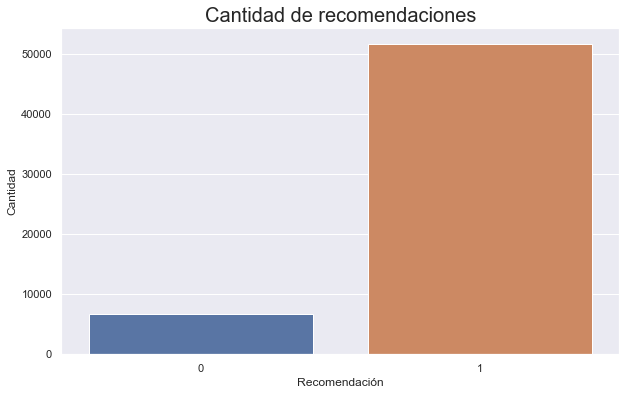

In [195]:
plt.figure(figsize=(10, 6))
sns.countplot(x=df_review_des['recommend'])

plt.xlabel('Recomendación')
plt.ylabel('Cantidad')
plt.title('Cantidad de recomendaciones', fontsize=20)
plt.show()

In [156]:
#Se convierte a valores cero y uno 
df_review_des['recommend'] = df_review_des['recommend'].astype(int)

Analisis columna 'Review':
- Se realizó el análisis de sentimientos utilizando la función analisis_sentimientos(review). Esta función utiliza la biblioteca TextBlob para evaluar la polaridad del sentimiento de cada texto. Devuelve (0) si el sentimiento es negativo, (1) si es neutral o (2) si es positivo. Después de un proceso iterativo y comparativo entre los resultados obtenidos, los textos analizados y la cantidad de ítems recomendados por los usuarios, se decidió que la función consideraría una polaridad < -0.3 para Negativo y una polaridad > 0 para Positivo.

In [140]:
print(conocer_columna (df_review_des,'review'))

Cantidad nulos: 0
Tipo de dato y cantidad:
<class 'str'>    58431
Name: review, dtype: int64


In [104]:
df_review_des['review'].head()

0    Simple yet with great replayability. In my opi...
1                 It's unique and worth a playthrough.
2    Great atmosphere. The gunplay can be a bit chu...
3    I know what you think when you see this title ...
4    For a simple (it's actually not all that simpl...
Name: review, dtype: object

In [118]:
# Funcion para el analisis de sentimientos de la columna review

def analisis_sentimientos(review):
        ''' 
         esta función utiliza la biblioteca TextBlob para analizar la polaridad 
         del sentimiento de cada texto de la columna 'review'. 
         Devuelve un valor numérico que indica si el sentimiento es negativo (0), neutral (1) o positivo (2).
        '''
        analizador = TextBlob(review)
        if analizador.sentiment.polarity < -0.3: # Negativo
            return 0  
        elif analizador.sentiment.polarity > 0: # Positivo
            return 2  
        else:
            return 1  # Neutral
df_review_des['sentiment_analysis'] = df_review_des['review'].apply(analisis_sentimientos)

In [119]:
df_review_des['sentiment_analysis'].value_counts()

2    33053
1    21492
0     3886
Name: sentiment_analysis, dtype: int64

In [128]:
# Comparo el valor numero obtenido para los sentimientos, la polaridad y el texto analizado

registros = [1,5,4,9,10,16]

for i in registros:
    calificacion = df_review_des['sentiment_analysis'][i]
    polaridad = round(TextBlob(df_review_des['review'][i]).sentiment.polarity,2)
    texto = df_review_des['review'][i]

    print(f"Calificacion:{calificacion}  Polaridad:{polaridad}  Texto:{texto}\n")

Calificacion:2  Polaridad:0.34  Texto:It's unique and worth a playthrough.

Calificacion:1  Polaridad:-0.1  Texto:Very fun little game to play when your bored or as a time passer. Very gud. Do Recommend. pls buy

Calificacion:1  Polaridad:-0.04  Texto:For a simple (it's actually not all that simple but it can be!) truck driving Simulator, it is quite a fun and relaxing game. Playing on simple (or easy?) its just the basic WASD keys for driving but (if you want) the game can be much harder and realistic with having to manually change gears, much harder turning, etc. And reversing in this game is a ♥♥♥♥♥, as I imagine it would be with an actual truck. Luckily, you don't have to reverse park it but you get extra points if you do cause it is bloody hard. But this is suprisingly a nice truck driving game and I had a bit of fun with it.

Calificacion:0  Polaridad:-0.33  Texto:Random drops and random quests, with stat points.  Animation style reminiscent of the era before the Voodoo card.

Ca

En el siguiente gráfico podemos ver de manera conjunta que la mayor cantidad de registros analizados fueron catalogados como Positivos o Neutros, lo cual está en concordancia con las recomendaciones generadas por los usuarios, las cuales son en su mayoría Positivas

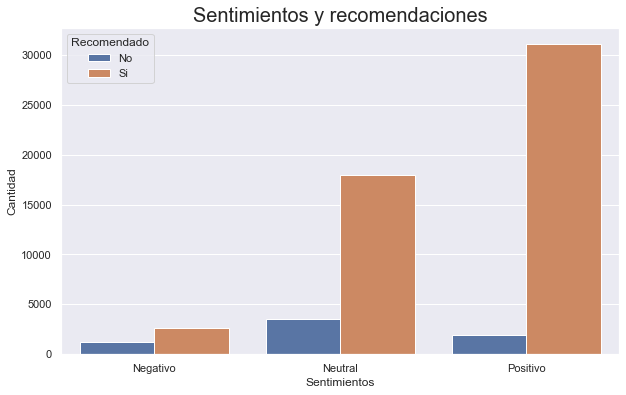

In [194]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df_review_des, x='sentiment_analysis', hue="recommend")

plt.xticks(ticks=[0, 1, 2], labels=['Negativo', 'Neutral', 'Positivo'])
plt.legend(title='Recomendado', labels=['No','Si'])

plt.xlabel('Sentimientos')
plt.ylabel('Cantidad')
plt.title('Sentimientos y Recomendaciones', fontsize=20)

plt.show()

Análisis columna 'posted':
- Se exploró el formato de los datos y se diseñó la función convertir_fecha(cadena_fecha) para transformar las fechas tipo 'Posted %B %d, %Y.' en un formato '%Y/%m/%d'.
- Se decidió eliminar los registros que no tenían año, ya que la información era incompleta.

In [141]:
print(conocer_columna (df_review_des,'posted'))

Cantidad nulos: 0
Tipo de dato y cantidad:
<class 'str'>    58431
Name: posted, dtype: int64


In [160]:
# registros en diferentes formatos
print(df_review_des['posted'][3])
print(df_review_des['posted'][59328])

Posted June 24, 2014.
Posted July 10.


In [161]:
def convertir_fecha(cadena_fecha):
    '''
    Esta funcion convierte una fecha tipo 'Posted %B %d, %Y.' en una fecha tipo '%Y/%m/%d' 
    Si el formato inicial de fecha es distinto, no hace nada'''
    try:
        fecha_objeto = datetime.strptime(cadena_fecha, 'Posted %B %d, %Y.')
        return fecha_objeto.strftime('%Y/%m/%d')
    except ValueError:
        return cadena_fecha

In [162]:
df_review_des['posted_ok'] = df_review_des['posted'].apply(convertir_fecha)

In [163]:
# Cantidad de registros que no se modificaron
df_review_des['posted_ok'].str.startswith('Post').sum()

9933

In [164]:
# Se decide eliminar esos registros, ya que la informacion esta incompleta
# Tal vez se podria tomar una decision mas acertada y e imputar esos registros desde alguna otra columna 

df_review_des_ano = df_review_des.drop(df_review_des[df_review_des['posted_ok'].str.startswith('Post')].index)

Teniendo en cuenta la información brindada en los datos; un usuario realizó varias reseñas (reviews) para diferentes juegos/items. Cada reseña está relacionada con un ítem y con una fecha de posteo 'posted_ok'. En el siguiente gráfico vemos que la cantidad de reseñas realizadas por los usuarios ha aumentado considerablemente con los años.

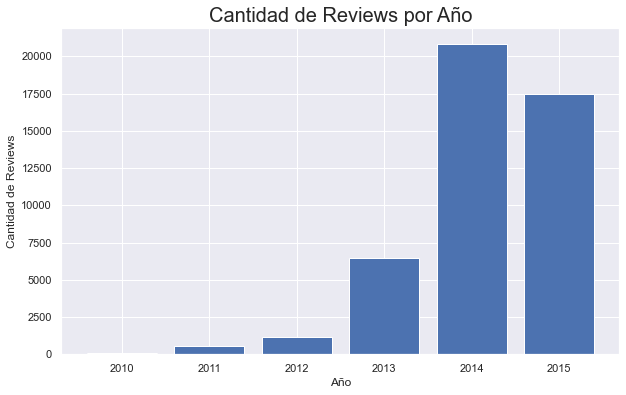

In [193]:
df_review_des_ano['posted_ok'] = pd.to_datetime(df_review_des_ano['posted_ok'])
df_review_des_ano['año'] = df_review_des_ano['posted_ok'].dt.year
df_review_por_año = df_review_des_ano.groupby('año')['review'].nunique()


plt.figure(figsize=(10, 6))
plt.bar(df_review_por_año.index, df_review_por_año.values)
plt.xlabel('Año')
plt.ylabel('Cantidad de Reviews')
plt.title('Cantidad de Reviews por Año', fontsize=20)
plt.show()

In [192]:
# df final 
df_review_final = df_review_des_ano.drop(columns=['posted','review'])

In [166]:
df_review_final.shape

(48498, 6)

In [167]:
df_review_final.head(1)

,user_id,user_url,item_id,recommend,sentiment_analysis,posted_ok
0,76561197970982479,http://steamcommunity.com/profiles/76561197970...,1250,1,2,2011/11/05


# Trabajamos con el DF de "users_items.json.gz"

In [196]:
df_items = pd.DataFrame (abrir_archivo_comprimido_2 ("Datos\\users_items.json.gz")) 
df_items.head(1)

,user_id,items_count,steam_id,user_url,items
0,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,"[{'item_id': '10', 'item_name': 'Counter-Strik..."


In [197]:
df_items.shape

(88310, 5)

In [198]:
df_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88310 entries, 0 to 88309
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      88310 non-null  object
 1   items_count  88310 non-null  int64 
 2   steam_id     88310 non-null  object
 3   user_url     88310 non-null  object
 4   items        88310 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.4+ MB


In [199]:
conocer_archivo (df_items,1)

["Columna: user_id   // Tipo dato: <class 'str'>   //  Informacion: js41637",
 "Columna: items_count   // Tipo dato: <class 'numpy.int64'>   //  Informacion: 888",
 "Columna: steam_id   // Tipo dato: <class 'str'>   //  Informacion: 76561198035864385",
 "Columna: user_url   // Tipo dato: <class 'str'>   //  Informacion: http://steamcommunity.com/id/js41637",
 'Columna: items   // Tipo dato: <class \'list\'>   //  Informacion: [{\'item_id\': \'10\', \'item_name\': \'Counter-Strike\', \'playtime_forever\': 0, \'playtime_2weeks\': 0}, {\'item_id\': \'80\', \'item_name\': \'Counter-Strike: Condition Zero\', \'playtime_forever\': 0, \'playtime_2weeks\': 0}, {\'item_id\': \'100\', \'item_name\': \'Counter-Strike: Condition Zero Deleted Scenes\', \'playtime_forever\': 0, \'playtime_2weeks\': 0}, {\'item_id\': \'300\', \'item_name\': \'Day of Defeat: Source\', \'playtime_forever\': 220, \'playtime_2weeks\': 0}, {\'item_id\': \'30\', \'item_name\': \'Day of Defeat\', \'playtime_forever\': 0, \'

In [200]:
df_items.iloc[0,4][1]

{'item_id': '20',
 'item_name': 'Team Fortress Classic',
 'playtime_forever': 0,
 'playtime_2weeks': 0}

In [201]:
###  Desanidar los datos de la columna 'items' 

# Abro el dicc que hay en 'items' para que cada elemento esté en una fila separada
df_items = df_items.explode('items').reset_index(drop=True)

# Desanido la 'reviews' en múltiples 'reviews's
df_items_des = pd.json_normalize(df_items['items'])

# Combino los dataframe
df_items_des= pd.concat([df_items.drop(columns=['items']), df_items_des], axis=1)

In [202]:
df_items_des.shape

(5170015, 8)

In [203]:
df_items_des.columns

Index(['user_id', 'items_count', 'steam_id', 'user_url', 'item_id',
       'item_name', 'playtime_forever', 'playtime_2weeks'],
      dtype='object')

In [204]:
# Registros completamente vacios
df_items_des[df_items_des.isna().all(axis=1)].sum()

user_id             0.0
items_count         0.0
steam_id            0.0
user_url            0.0
item_id             0.0
item_name           0.0
playtime_forever    0.0
playtime_2weeks     0.0
dtype: float64

In [205]:
# Registros duplicados
df_items_des[df_items_des.duplicated()].count()

user_id             59196
items_count         59196
steam_id            59196
user_url            59196
item_id             59104
item_name           59104
playtime_forever    59104
playtime_2weeks     59104
dtype: int64

In [206]:
# Elimino Registros duplicados
df_items_des = df_items_des.drop_duplicates()

In [207]:
# me quedo con un df mas pequeño, solo con las columnas que necesitare
df_items_des_small = df_items_des[['user_id','item_id','user_url','playtime_forever']]
df_items_des_small.head(1)

,user_id,item_id,user_url,playtime_forever
0,76561197970982479,10,http://steamcommunity.com/profiles/76561197970...,6.0


Analisis de la columna 'user_id'

In [208]:
print(conocer_columna (df_items_des_small,'user_id'))

Cantidad nulos: 0
Tipo de dato y cantidad:
<class 'str'>    5110819
Name: user_id, dtype: int64


Analisis columna 'user_url'

In [209]:
print(conocer_columna (df_items_des_small,'user_url'))

Cantidad nulos: 0
Tipo de dato y cantidad:
<class 'str'>    5110819
Name: user_url, dtype: int64


Analisis columna item_id y Analisis de la columna 'playtime_forever':
- Luego de comprobar que la cantidad de nulos en la columna 'item_id' también son nulos en la columna 'playtime_forever', se decide eliminar estos registros, ya que para los fines prácticos de las funciones no me sirve tener 'user_id' o 'user_url' si no tengo datos en 'item_id' o 'playtime_forever'

In [210]:
print(conocer_columna (df_items_des_small,'item_id'))

Cantidad nulos: 16714
Tipo de dato y cantidad:
<class 'str'>      5094105
<class 'float'>      16714
Name: item_id, dtype: int64


In [211]:
print(conocer_columna (df_items_des_small,'playtime_forever'))

Cantidad nulos: 16714
Tipo de dato y cantidad:
<class 'float'>    5110819
Name: playtime_forever, dtype: int64


In [212]:
# evaluo si los registros con 'item_id' null tambien tienen 'playtime_forever' null
nulos = df_items_des_small['item_id'].isna() & df_items_des_small['playtime_forever'].isna()

df_items_des_small[nulos].count()

user_id             16714
item_id                 0
user_url            16714
playtime_forever        0
dtype: int64

In [213]:
# se eliminan los registros con datos nulos en las columna 'item_id' y 'playtime_forever'
df_items_final= df_items_des_small.drop(df_items_des_small[nulos].index)

In [54]:
df_items_final.shape

(5094105, 4)

In [56]:
df_items_final.head(1)

,user_id,item_id,user_url,playtime_forever
0,76561197970982479,10,http://steamcommunity.com/profiles/76561197970...,6.0


# Trabajamos con el DF de "steam_games.json.gz"

In [217]:
df_steam = pd.DataFrame (abrir_archivo_comprimido_1 ("Datos\\steam_games.json.gz")) 
df_steam.head(1)

,publisher,genres,app_name,title,url,release_date,tags,reviews_url,discount_price,specs,price,early_access,id,metascore,developer,user_id,steam_id,items,items_count
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,76561197970982479,76561197970982479,"[{'item_id': '10', 'item_name': 'Counter-Strik...",277.0


In [218]:
df_steam.shape

(120445, 19)

In [59]:
df_steam.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120445 entries, 0 to 120444
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   publisher       24083 non-null  object 
 1   genres          28852 non-null  object 
 2   app_name        32133 non-null  object 
 3   title           30085 non-null  object 
 4   url             32135 non-null  object 
 5   release_date    30068 non-null  object 
 6   tags            31972 non-null  object 
 7   reviews_url     32133 non-null  object 
 8   discount_price  225 non-null    float64
 9   specs           31465 non-null  object 
 10  price           30758 non-null  object 
 11  early_access    32135 non-null  object 
 12  id              32133 non-null  object 
 13  metascore       2677 non-null   object 
 14  developer       28836 non-null  object 
 15  user_id         88310 non-null  object 
 16  steam_id        88310 non-null  object 
 17  items           88310 non-nul

In [219]:
conocer_archivo (df_steam,1)

["Columna: publisher   // Tipo dato: <class 'float'>   //  Informacion: nan",
 "Columna: genres   // Tipo dato: <class 'float'>   //  Informacion: nan",
 "Columna: app_name   // Tipo dato: <class 'float'>   //  Informacion: nan",
 "Columna: title   // Tipo dato: <class 'float'>   //  Informacion: nan",
 "Columna: url   // Tipo dato: <class 'float'>   //  Informacion: nan",
 "Columna: release_date   // Tipo dato: <class 'float'>   //  Informacion: nan",
 "Columna: tags   // Tipo dato: <class 'float'>   //  Informacion: nan",
 "Columna: reviews_url   // Tipo dato: <class 'float'>   //  Informacion: nan",
 "Columna: discount_price   // Tipo dato: <class 'numpy.float64'>   //  Informacion: nan",
 "Columna: specs   // Tipo dato: <class 'float'>   //  Informacion: nan",
 "Columna: price   // Tipo dato: <class 'float'>   //  Informacion: nan",
 "Columna: early_access   // Tipo dato: <class 'float'>   //  Informacion: nan",
 "Columna: id   // Tipo dato: <class 'float'>   //  Informacion: nan",

In [220]:
df_steam.iloc[0,17][1]

{'item_id': '20',
 'item_name': 'Team Fortress Classic',
 'playtime_forever': 0,
 'playtime_2weeks': 0}

In [221]:
df_steam.columns

Index(['publisher', 'genres', 'app_name', 'title', 'url', 'release_date',
       'tags', 'reviews_url', 'discount_price', 'specs', 'price',
       'early_access', 'id', 'metascore', 'developer', 'user_id', 'steam_id',
       'items', 'items_count'],
      dtype='object')

In [222]:
# luego de ver las funciones que se piden y los datos que tengo, decido quedarme con las siguientes columnas
df_steam_redu = df_steam[['genres','release_date', 'price','id', 'developer']]
df_steam_redu = df_steam_redu.rename(columns={'id': 'item_id'})

In [224]:
df_steam_redu.shape

(120445, 5)

In [232]:
## cantidad de filas completamente vacias
df_steam_redu.isna().all(axis=1).sum()

88310

In [233]:
# elimino las filas que estan completamnete bacias
df_steam_redu = df_steam_redu.dropna(how='all')

In [234]:
# Registros duplicados
df_items_des[df_items_des.duplicated()].count()

user_id             0
items_count         0
steam_id            0
user_url            0
item_id             0
item_name           0
playtime_forever    0
playtime_2weeks     0
dtype: int64

In [235]:
df_steam_redu.isna().sum()

genres          3283
release_date    2067
price           1377
item_id            2
developer       3299
dtype: int64

Analisis columna 'item_id':
- Se exploro cantidad de nulos y duplicados. Se eliminaron dichos registros
- Se exploro registros que tienen todos los campos nulos exepto 'item_id'. Se eliminaron

In [236]:
print(conocer_columna (df_steam_redu,'item_id'))

Cantidad nulos: 2
Tipo de dato y cantidad:
<class 'str'>      32133
<class 'float'>        2
Name: item_id, dtype: int64


In [237]:
# elimino valores nulos
df_steam_redu = df_steam_redu.dropna(subset=['item_id'])

In [240]:
# Analisis de elementos duplicados
df_steam_redu['item_id'].duplicated().sum()

1

In [241]:
# elimino duplicados
df_steam_redu = df_steam_redu.drop_duplicates(subset=['item_id'])

In [248]:
# Evaluo si tengo registros que tienen todos los campos nulos exepto 'item_id'
nulos = df_steam_redu[['release_date', 'genres', 'price', 'developer']].isna().all(axis=1)
print(df_steam_redu[nulos].count())

genres            0
release_date      0
price             0
item_id         116
developer         0
dtype: int64


In [249]:
# Se eliminan estos registros ya que si no tengo 'ited_id' no me sirve
df_steam_redu = df_steam_redu.drop(df_steam_redu[nulos].index)

Analisis columna 'release_date':
- Se realizó un análisis exploratorio para revisar los datos existentes.
- Se reemplazaron los datos nulos por "1900-01-01".
- Se realizaron reemplazos de fechas específicas que arrojaban errores.
- Se transformaron los datos posibles al formato de fecha.
- Los datos que no pudieron ser transformados al formato de fecha debido a la falta de información (por ejemplo, 'Oct 2010') o por que eran outliers se convirtieron en nulos y se reemplazaron por "1900-01-01".
- Se agregó una columna año.
- Se evaluo la cantidad que presentaba la fecha "1900-01-01" en relacion al total de los datos. Se decidio eliminar esos datos, ya que son pocos en comparación con el total de datos

In [301]:
print(conocer_columna (df_steam_redu,'release_date'))

Cantidad nulos: 1950
Tipo de dato y cantidad:
<class 'str'>      30066
<class 'float'>     1950
Name: release_date, dtype: int64


In [ ]:
# Se exportan los datos para poder ver mas detalles
#df_steam_redu[['release_date','item_id']].to_json("DataSets/release_date.json", orient="records", lines=True)

In [302]:
df_steam_redu_fecha = df_steam_redu.copy()

In [303]:
# Se observaron varios errores en los datos de esta columna

# remplazo los nulos por "1900-01-01"
df_steam_redu_fecha['release_date']=df_steam_redu_fecha['release_date'].fillna("1900-01-01")

# hay un registro que tiene cambiado el formato de fecha, se lo arregla
indice = df_steam_redu_fecha[df_steam_redu_fecha['release_date']=='15.01.2018'].index[0]
df_steam_redu_fecha.loc[indice, 'release_date'] = '2018/01/15'

# llevo a formato fecha
# los registros que son'Oct 2010' o algun oulier se convierten en nulos
df_steam_redu_fecha['release_date'] = pd.to_datetime(df_steam_redu_fecha['release_date'], errors='coerce')

# los registros nulos se remplazan por "1900-01-01"
df_steam_redu_fecha['release_date']=df_steam_redu_fecha['release_date'].fillna("1900-01-01")

In [304]:
print(conocer_columna (df_steam_redu_fecha,'release_date'))

Cantidad nulos: 0
Tipo de dato y cantidad:
<class 'pandas._libs.tslibs.timestamps.Timestamp'>    32016
Name: release_date, dtype: int64


En el siguiente gráfico se pueden observar que la cantidad de datos que fueron reemplazados por "1900-01-01" podrían eliminarse, ya que son pocos en comparación con el total de datos

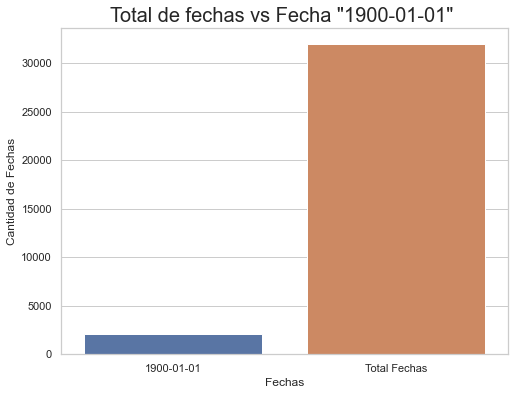

In [333]:
# Calculo la cantidad total de fechas y la cantidad que son igual a '1900-01-01'
fechas_1900 = (df_steam_redu_fecha['release_date'] == pd.to_datetime('1900-01-01')).sum()
fechas_total = df_steam_redu_fecha.shape[0]

plt.figure(figsize=(8, 6))
sns.barplot(x=['1900-01-01', 'Total Fechas'], y=[fechas_1900, fechas_total])

plt.xlabel('Fechas')
plt.ylabel('Cantidad de Fechas')
plt.title('Total de fechas vs Fecha "1900-01-01" ', fontsize=20)
plt.show()


In [334]:
# se eliminan las fechas = '1900-01-01'
df_steam_redu_fecha = df_steam_redu_fecha[df_steam_redu_fecha['release_date'] != pd.to_datetime('1900-01-01')]

In [336]:
df_steam_redu_fecha.shape

(29892, 6)

In [ ]:
# agrego una columna 'Año'
df_steam_redu_fecha['año'] = df_steam_redu_fecha['release_date'].dt.year

En el siguiente gráfico vemos un notorio aumento en la cantidad de juegos lanzados en la plataforma a medida que pasan los años.

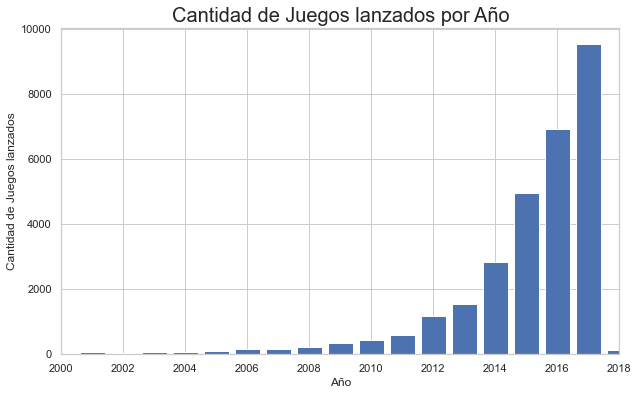

In [340]:
# agrupo la cantidad de items por año
df_item_por_año = df_steam_redu_fecha.groupby('año')['item_id'].nunique()


plt.figure(figsize=(10, 6))
plt.bar(df_item_por_año.index, df_item_por_año.values)
plt.xlim(2000, 2018)
plt.xlabel('Año')
plt.ylabel('Cantidad de Juegos lanzados')
plt.title('Cantidad de Juegos lanzados por Año', fontsize=20)
plt.show()

Analisis columna 'genres'

In [341]:
print(conocer_columna (df_steam_redu_fecha,'genres'))

Cantidad nulos: 1234
Tipo de dato y cantidad:
<class 'list'>     28658
<class 'float'>     1234
Name: genres, dtype: int64


Analisis columna 'developer'

In [342]:
print(conocer_columna (df_steam_redu_fecha,'developer'))

Cantidad nulos: 1250
Tipo de dato y cantidad:
<class 'str'>      28642
<class 'float'>     1250
Name: developer, dtype: int64


Analisis de la columna 'price':
- Se exploró si existían datos con valor igual a cero y la cantidad de valores que empezaban con la palabra 'Free'.
- Se reemplazaron todos los valores que fueran tipo string y contenían la palabra 'Free' por cero.
- Se exploró qué valores de tipo string quedaban, los que hacían referencia a valores "FREE" se los reemplazó por cero y los demás se eliminaron.

In [343]:
print(conocer_columna (df_steam_redu_fecha,'price'))

Cantidad nulos: 1076
Tipo de dato y cantidad:
<class 'float'>    28313
<class 'str'>       1579
Name: price, dtype: int64


In [344]:
# evaluo los datoas flotates
numero= df_steam_redu_fecha[df_steam_redu_fecha['price'].apply(lambda x: isinstance(x, float))]['price']
# veo si hay flotantes igual a cero 
numero[numero==float(0)]

Series([], Name: price, dtype: object)

In [345]:
# evaluo la cantidad de valores free
df_steam_redu_fecha['price'].str.startswith('Free').count()

1579

In [346]:
# remplazo todos los str que sean free por cero en formato float

df_steam_redu_fecha_price=df_steam_redu_fecha.copy()
free_str = (df_steam_redu_fecha_price['price'].str.startswith('Free')) & (df_steam_redu_fecha_price['price'].apply(type) == str)
df_steam_redu_fecha_price.loc[free_str, 'price'] = 0.0

In [347]:
print(conocer_columna (df_steam_redu_fecha_price,'price'))

Cantidad nulos: 1076
Tipo de dato y cantidad:
<class 'float'>    29880
<class 'str'>         12
Name: price, dtype: int64


In [348]:
# veo cuales son los str que quedaron
df_steam_redu_fecha_price['price'][df_steam_redu_fecha_price['price'].apply(type) == str]

89279                    Play for Free!
89291                    Play for Free!
90715                       Install Now
91181     Play WARMACHINE: Tactics Demo
92142                     Install Theme
92228                       Third-party
92336                          Play Now
111044                    Play the Demo
113310              Starting at $499.00
113311              Starting at $449.00
114527                         Play Now
120148                      Third-party
Name: price, dtype: object

In [349]:
# Play for Free! lo pongo 0.0
free = df_steam_redu_fecha_price['price'] == 'Play for Free!'
df_steam_redu_fecha_price.loc[free, 'price'] = 0.0

In [350]:
# elimino el resto de outliers
eliminar = ['Play WARMACHINE: Tactics Demo', 'Install Theme', 'Third-party', 'Play Now', 'Starting at $499.00',
            'Install Now', 'Play the Demo']
df_steam_redu_fecha_price = df_steam_redu_fecha_price[~df_steam_redu_fecha_price['price'].isin(eliminar)]

In [351]:
# veo si queda algun str
df_steam_redu_fecha_price['price'][df_steam_redu_fecha_price['price'].apply(type) == str]

113311    Starting at $449.00
Name: price, dtype: object

In [352]:
# convierto el que me queda
free = df_steam_redu_fecha_price.index==113311
df_steam_redu_fecha_price.loc[free, 'price'] = 0.0

In [353]:
print(conocer_columna (df_steam_redu_fecha_price,'price'))

Cantidad nulos: 1076
Tipo de dato y cantidad:
<class 'float'>    29883
Name: price, dtype: int64


In [354]:
df_steam_final = df_steam_redu_fecha_price.copy()
df_steam_final.head(1)

,genres,release_date,price,item_id,developer,año
88310,"[Action, Casual, Indie, Simulation, Strategy]",2018-01-04,4.99,761140,Kotoshiro,2018


# FUNCIONES

 - Se trabajó con cada función de manera independiente con el principal objetivo de generar un archivo tipo JSON lo más pequeño posible para que este sea consumido desde la API. Reduciendo así el almacenamiento usado en la plataforma Render y la velocidad de respuesta de la API.

# Funcion COUNTREVIEWS

def countreviews( YYYY-MM-DD y YYYY-MM-DD : str ): Cantidad de usuarios que realizaron reviews entre las fechas dadas y, el porcentaje de recomendación de los mismos en base a reviews.recommend.

- Se filtraron las columnas necesarias para preparar los archivos para la función.
- Se determinó la existencia de nulos o duplicados, y se eliminaron en los casos necesarios.
- Se eliminaron las columnas que no usará la función.
- Se exportó el DataFrame en formato JSON.

In [355]:
df_review_final.head(1)

,user_id,user_url,item_id,recommend,sentiment_analysis,posted_ok,año
0,76561197970982479,http://steamcommunity.com/profiles/76561197970...,1250,1,2,2011-11-05,2011


In [356]:
# Me quedo con 'user_id','posted_ok'y'recommend' que es lo que necesito, 
# y con 'item_id', ya que 'posted_ok'y'recommend' estan a nivel de 'item_id'
# Si hay 'posted_ok' tambien hubo reviews.

df_countreviews = df_review_final[['user_id','item_id', 'posted_ok','recommend']]
df_countreviews.head(1)

,user_id,item_id,posted_ok,recommend
0,76561197970982479,1250,2011-11-05,1


In [360]:
# Registros completamente vacios
df_countreviews[df_countreviews.isna().all(axis=1)].count()

user_id      0
item_id      0
posted_ok    0
recommend    0
dtype: int64

In [359]:
# Registros duplicados
df_countreviews[df_countreviews.duplicated()].count()

user_id      0
item_id      0
posted_ok    0
recommend    0
dtype: int64

In [361]:
# Ahora que ya corrobore que no hay nulos ni duplicados, puedo elimnar la columna item_id
df_countreviews = df_countreviews.drop(columns=['item_id','user_id'])

In [496]:
# Convierto la fecha a formato '%Y-%m-%d'
df_countreviews['posted_ok'] = pd.to_datetime(df_countreviews['posted_ok'])
df_countreviews['posted_ok'] = df_countreviews['posted_ok'].dt.strftime('%Y-%m-%d')


In [497]:
df_countreviews.shape

(48498, 2)

In [498]:
df_countreviews.head(1)

,posted_ok,recommend
0,2011-11-05,1


In [499]:
#df_countreviews.to_json("DataSets/df_countreviews.json", orient="records", lines=True)

# Funcion GENRES

def genre( género : str ): Devuelve el puesto en el que se encuentra un género sobre el ranking de los mismos analizado bajo la columna PlayTimeForever.

- Se filtraron las columnas necesarias para preparar los archivos para la función.
- Se determinó la existencia de nulos o duplicados, y se eliminaron en los casos necesarios.
- En este caso se trabajó primero con la columna género del archivo Steam. Se exploró la columna género con la función explode(). Se eliminaron nulos y se analizó qué palabras únicas se encontraban dentro. Se eliminó todo lo que no era género de videojuegos.
- Luego se unió con las columnas necesarias del archivo Item utilizando la función pd.merge() usando 'item_id' como clave.
- Se agrupó la información por géneros usando groupby() y luego se ordenó con sort_values().
- Se agregó una columna que indica el ranking de cada género.
- Se pasó a minúscula la columna género con lower().
- Se eliminaron las columnas que no usará la función.
- Se exportó el DataFrame en formato JSON.

In [365]:
df_item_genres = df_steam_final[['genres', 'item_id']]

In [366]:
# descompongo la lista de generos
df_item_genres = df_item_genres.explode('genres')

In [367]:
df_item_genres['genres'].isna().sum()

1233

In [368]:
# Elimino los registros donde 'genres' es nulo
df_item_genres = df_item_genres.dropna(subset=['genres'])

In [369]:
# Veo que hay adentro de 'genres'
df_item_genres['genres'].unique()

array(['Action', 'Casual', 'Indie', 'Simulation', 'Strategy',
       'Free to Play', 'RPG', 'Sports', 'Adventure', 'Racing',
       'Massively Multiplayer', 'Early Access',
       'Animation &amp; Modeling', 'Video Production', 'Web Publishing',
       'Education', 'Software Training', 'Utilities',
       'Design &amp; Illustration', 'Audio Production', 'Photo Editing',
       'Accounting'], dtype=object)

In [370]:
# Elimino todo lo que no es genero de pelicula

eliminar = ['Free to Play','Early Access','Animation &amp; Modeling','Video Production','Utilities',
            'Web Publishing','Education','Software Training','Design &amp; Illustration',
            'Audio Production','Photo Editing','Accounting']

condicion = ~df_item_genres['genres'].isin(eliminar)
df_item_genres = df_item_genres[condicion]

In [371]:
df_item_genres.shape

(65764, 2)

In [372]:
df_item_genres.head(1)

,genres,item_id
88310,Action,761140


In [373]:
# creo un df con 'item' y 'playtime_forever'
df_item_playtime = df_items_final[['item_id','playtime_forever']]

In [374]:
df_item_playtime['playtime_forever'].isna().sum()

0

In [375]:
df_item_playtime.shape

(5094105, 2)

In [376]:
df_item_playtime.head(1)

,item_id,playtime_forever
0,10,6.0


In [377]:
# junto las dos tablas a travez del 'item_id'
df_genre = pd.merge(df_item_genres,df_item_playtime, on='item_id')

In [378]:
df_genre = df_genre.drop(columns=['item_id'])

In [379]:
df_genre.head(1)

,genres,playtime_forever
0,Action,5.0


In [380]:
# agrupo por 'item_id' y sumo  los 'price'
df_genre = df_genre.groupby('genres')['playtime_forever'].sum().reset_index()
df_genre.head(3)

,genres,playtime_forever
0,Action,3.070370e+09
1,Adventure,8.940376e+08
2,Casual,2.490610e+08


In [381]:
# ordeno segun los valores de la columna 'playtime_forever'
df_genre_orden = df_genre.sort_values(by='playtime_forever', ascending=False)

In [382]:
# agrego una columna para enumerar el orden
df_genre_orden['ranking'] = range(1, 11)

In [383]:
df_genre_orden.head(3)

,genres,playtime_forever,ranking
0,Action,3.070370e+09,1
3,Indie,1.475225e+09,2
5,RPG,1.027724e+09,3


In [387]:
df_genre_ranking = df_genre_orden[['genres','ranking']].copy()

# convierto a minuscula para evitar errores
df_genre_ranking['genres'] = df_genre_ranking['genres'].str.lower()

In [388]:
df_genre_ranking.head(1)

,genres,ranking
0,action,1


In [389]:
#df_genre_ranking.to_json("DataSets/df_genre.json", orient="records", lines=True)

# Funcion USERFORGENRE

def userforgenre( género : str ): Top 5 de usuarios con más horas de juego en el género dado, con su URL (del user) y user_id.

- Se filtraron las columnas necesarias para preparar los archivos para la función.
- Se determinó la existencia de nulos o duplicados, y se eliminaron en los casos necesarios.
- Se unió las columnas utilizando la función pd.merge() usando 'item_id' como clave.
- Diseñe la funcion ranking_genero (genero) que recibe un genero y devulve un df con un Top 5 de usuarios con más horas de juego (sum de playtime_forever) en el género dado, su user_url y user_id. Apliqué esta función a cada uno de los generos existentes y luego concatene los DataFrame usando pd.concat()
- Se pasó a minúscula la columna género con lower().
- Se eliminaron las columnas que no usará la función.
- Se exportó el DataFrame en formato JSON.

In [390]:
df_item_genres.head(1)

,genres,item_id
88310,Action,761140


In [391]:
df_items_final.head(1)

,user_id,item_id,user_url,playtime_forever
0,76561197970982479,10,http://steamcommunity.com/profiles/76561197970...,6.0


In [392]:
# junto las dos tablas a travez del 'item_id'
df_userforgenre_inicial = pd.merge(df_item_genres,df_items_final, on='item_id')

In [393]:
df_userforgenre_inicial = df_userforgenre_inicial.drop(columns=['item_id','user_url']) # elimino columnas

In [394]:
df_userforgenre_inicial.head(2)

,genres,user_id,playtime_forever
0,Action,UTNerd24,5.0
1,Action,I_DID_911_JUST_SAYING,0.0


In [395]:
def ranking_genero (genero):
    ''' Esta funcion recibe un genero y devulve un df con un Top 5 de usuarios 
    con más horas de juego (sum de playtime_forever) en el género dado, su user_url y user_id '''

    df_final = pd.DataFrame()
    df_final = df_userforgenre_inicial[df_userforgenre_inicial['genres'] == genero] # hago un df por genero
    df_final = df_final.drop(columns=['genres']) # elimino columna genero
    df_final = df_final.groupby('user_id')['playtime_forever'].sum().reset_index() # agrupo por 'user_id' y sumo 'play'
    df_final = df_final.sort_values(by='playtime_forever', ascending=False) # ordeno segun los valores de la columna 'playtime_forever'
    df_final = df_final.head(5).copy() # me quedo con los 5 primeros
    df_final['ranking'] = range(1, 6)# agrego una columna para enumerar el orden
    df_final['genres'] = genero # agrego la columna de genero
    df_final['user_url'] = None # genero una columna de url

    # para ponerle el 'user_url' a cada 'user_id'
    for elemento in df_final['user_id']:
        filtrado = df_items_final.loc[df_items_final['user_id'] == elemento, 'user_url']
        df_final.loc[df_final['user_id'] == elemento, 'user_url'] = filtrado.values[0]
    return df_final

In [396]:
df_userforgenre_inicial['genres'].unique()

array(['Action', 'Indie', 'Racing', 'Strategy', 'RPG', 'Simulation',
       'Casual', 'Adventure', 'Sports', 'Massively Multiplayer'],
      dtype=object)

In [397]:
genero = 'Action'
df_userforgenre_action = ranking_genero (genero)
df_userforgenre_action.head(1)

,user_id,playtime_forever,ranking,genres,user_url
50650,Sp3ctre,1697650.0,1,Action,http://steamcommunity.com/id/Sp3ctre


In [399]:
genero = 'Indie'
df_userforgenre_indie = ranking_genero (genero)
df_userforgenre_indie.head(1)

,user_id,playtime_forever,ranking,genres,user_url
46547,REBAS_AS_F-T,2402994.0,1,Indie,http://steamcommunity.com/id/REBAS_AS_F-T


In [400]:
genero = 'Racing'
df_userforgenre_racing = ranking_genero (genero)
df_userforgenre_racing.head(1)

,user_id,playtime_forever,ranking,genres,user_url
16798,DownSyndromeKid,743445.0,1,Racing,http://steamcommunity.com/id/DownSyndromeKid


In [401]:
genero = 'Strategy'
df_userforgenre_strategy = ranking_genero (genero)
df_userforgenre_strategy.head(1)

,user_id,playtime_forever,ranking,genres,user_url
52336,shinomegami,1141546.0,1,Strategy,http://steamcommunity.com/id/shinomegami


In [402]:
genero = 'RPG'
df_userforgenre_rpg = ranking_genero (genero)
df_userforgenre_rpg.head(1)

,user_id,playtime_forever,ranking,genres,user_url
56591,shinomegami,1060592.0,1,RPG,http://steamcommunity.com/id/shinomegami


In [403]:
genero = 'Simulation'
df_userforgenre_simulation = ranking_genero (genero)
df_userforgenre_simulation.head(1)

,user_id,playtime_forever,ranking,genres,user_url
50396,jimmynoe,1062130.0,1,Simulation,http://steamcommunity.com/id/jimmynoe


In [404]:
genero = 'Casual'
df_userforgenre_casual = ranking_genero (genero)
df_userforgenre_casual.head(1)

,user_id,playtime_forever,ranking,genres,user_url
39757,REBAS_AS_F-T,1224933.0,1,Casual,http://steamcommunity.com/id/REBAS_AS_F-T


In [405]:
genero = 'Adventure'
df_userforgenre_adventure = ranking_genero (genero)
df_userforgenre_adventure.head(1)

,user_id,playtime_forever,ranking,genres,user_url
44711,REBAS_AS_F-T,2183682.0,1,Adventure,http://steamcommunity.com/id/REBAS_AS_F-T


In [406]:
genero ='Sports'
df_userforgenre_sports = ranking_genero (genero)
df_userforgenre_sports.head(1)

,user_id,playtime_forever,ranking,genres,user_url
1476,76561197995725436,193206.0,1,Sports,http://steamcommunity.com/profiles/76561197995...


In [407]:
genero = 'Massively Multiplayer'
df_userforgenre_massi = ranking_genero (genero)
df_userforgenre_massi.head(1)

,user_id,playtime_forever,ranking,genres,user_url
35215,Evilutional,688260.0,1,Massively Multiplayer,http://steamcommunity.com/id/Evilutional


In [408]:
# concateno todos los ranking
df_userforgenre = pd.concat([df_userforgenre_massi,df_userforgenre_action, df_userforgenre_adventure,
                             df_userforgenre_casual, df_userforgenre_indie, df_userforgenre_strategy,
                             df_userforgenre_racing, df_userforgenre_rpg, df_userforgenre_sports,
                             df_userforgenre_simulation]).reset_index(drop=True)

In [409]:
df_userforgenre.head(4)

,user_id,playtime_forever,ranking,genres,user_url
0,Evilutional,688260.0,1,Massively Multiplayer,http://steamcommunity.com/id/Evilutional
1,shinomegami,638699.0,2,Massively Multiplayer,http://steamcommunity.com/id/shinomegami
2,76561198041627248,457103.0,3,Massively Multiplayer,http://steamcommunity.com/profiles/76561198041...
3,76561198050414588,454132.0,4,Massively Multiplayer,http://steamcommunity.com/profiles/76561198050...


In [428]:
df_userforgenre = df_userforgenre.drop(columns=['playtime_forever'])

In [410]:
df_userforgenre['genres'] = df_userforgenre['genres'].str.lower()

In [429]:
#df_userforgenre.to_json("DataSets/df_userforgenre.json", orient="records", lines=True)

# Funcion DEVELOPER

def developer( desarrollador : str ): Cantidad de items y porcentaje de contenido Free por año según empresa desarrolladora. Ejemplo de salida:

- Se filtraron las columnas necesarias para preparar los archivos para la función.
- Se determinó la existencia de nulos o duplicados, y se eliminaron en los casos necesarios.
- Se evaluó la existencia de registros donde 'price' o 'devolper' fueran nulos. Se eliminaron ya que la informacion necesaria esta incompleta sin uno de los dos.
- Se pasó a minúscula la columna 'developer' con lower().
- Se eliminaron las columnas que no usará la función.
- Se exportó el DataFrame en formato JSON.

In [412]:
df_steam_final.head(1)

,genres,release_date,price,item_id,developer,año
88310,"[Action, Casual, Indie, Simulation, Strategy]",2018-01-04,4.99,761140,Kotoshiro,2018


In [430]:
# me quedo con la columnas necesarias
df_steam_developer = df_steam_final[['año', 'price', 'item_id', 'developer']]

In [431]:
df_steam_developer.head(5)

,año,price,item_id,developer
88310,2018,4.99,761140,Kotoshiro
88311,2018,0.0,643980,Secret Level SRL
88312,2017,0.0,670290,Poolians.com
88313,2017,0.99,767400,彼岸领域
88315,2018,3.99,772540,Trickjump Games Ltd


In [432]:
# Registros completamente vacios
print(df_steam_developer [df_steam_developer .isna().all(axis=1)].count())
# Registros duplicados
print(df_steam_developer [df_steam_developer .duplicated()].count())

año          0
price        0
item_id      0
developer    0
dtype: int64
año          0
price        0
item_id      0
developer    0
dtype: int64


In [433]:
df_steam_developer.shape

(29883, 4)

In [434]:
# registros que price o devolper son nan (no hay ningun registro nulo en item_id)
# los elimino porque tendre la infomacion incompleta
eliminar = df_steam_developer[(df_steam_developer['price'].isnull() | df_steam_developer['developer'].isnull())]
df_steam_developer_elim = df_steam_developer[~df_steam_developer.index.isin(eliminar.index)]

In [ ]:
# convierto los developers a minuscula
df_steam_developer_elim ['developer'] = df_steam_developer_elim ['developer'].str.lower()

In [436]:
# veo cuantos Nan hay en 'developer'
df_steam_developer_elim [df_steam_developer_elim ['developer'].isna()].shape

(0, 4)

In [437]:
# veo cuantos Nan hay en 'price'
df_steam_developer_elim [df_steam_developer_elim ['price'].isna()].shape

(0, 4)

In [438]:
df_steam_developer_elim.head(2)

,año,price,item_id,developer
88310,2018,4.99,761140,kotoshiro
88311,2018,0.0,643980,secret level srl


In [439]:
#df_steam_developer_elim.to_json("DataSets/df_developer.json", orient="records", lines=True)

# Funcion SENTIMENT_ANALYSIS

def sentiment_analysis( año : int ): Según el año de lanzamiento, se devuelve una lista con la cantidad de registros de reseñas de usuarios que se encuentren categorizados con un análisis de sentimiento.

                    Ejemplo de retorno: {Negative = 182, Neutral = 120, Positive = 278}

- Se filtraron las columnas necesarias para preparar los archivos para la función.
- Se determinó la existencia de nulos o duplicados, y se eliminaron en los casos necesarios.
- Se unieron los datos de años y sentimientos a traves de pd.merge(on='item_id')
- Se creó un dataframe para cargar los años y las cantidades de cada sentimiento. Luego se remplazo cada valor por la cantidad total de sentimientos 0, 1 o 2 que habia para cada año
- Se eliminaron las columnas que no usará la función.
- Se exportó el DataFrame en formato JSON.

In [427]:
df_steam_final.head(1)

,genres,release_date,price,item_id,developer,año
88310,"[Action, Casual, Indie, Simulation, Strategy]",2018-01-04,4.99,761140,Kotoshiro,2018


In [440]:
df_item_date = df_steam_final[['año', 'item_id']]

In [442]:
df_review_final.head(1)

,user_id,user_url,item_id,recommend,sentiment_analysis,posted_ok,año
0,76561197970982479,http://steamcommunity.com/profiles/76561197970...,1250,1,2,2011-11-05,2011


In [443]:
df_item_sentiment = df_review_final[['item_id', 'sentiment_analysis']]

In [444]:
df_sentiment_inicial = pd.merge(df_item_date, df_item_sentiment, on='item_id')

In [445]:
df_sentiment_inicial = df_sentiment_inicial.drop(columns=['item_id'])

In [446]:
df_sentiment_inicial['año'].unique()

array([1998, 2006, 2005, 2000, 2007, 1995, 1994, 2001, 2004, 2003, 2008,
       1997, 1993, 2009, 2002, 2010, 2011, 2013, 2012, 2015, 1996, 2014,
       1992, 2016, 1989, 2017, 1999, 1991, 1990], dtype=int64)

In [447]:
# creo un dataframe para cargar los años y las cantidades de cada sentimiento
df_sentiment = pd.DataFrame(columns=['ano','cantidad_0','cantidad_1','cantidad_2'])
df_sentiment['ano']=df_sentiment_inicial['año'].unique()

In [448]:
# remplazo cada nan por la cantidad de sentimientos 0, 1 o 2 que hay para cada año
for elemento in df_sentiment['ano']:
    conteo_sentiment = df_sentiment_inicial['sentiment_analysis'][df_sentiment_inicial['año']==elemento].value_counts()

    # si no hay elemento en ese año, le pongo 0
    df_sentiment.loc[df_sentiment['ano'] == elemento, 'cantidad_0'] = conteo_sentiment.get(0,0) 
    df_sentiment.loc[df_sentiment['ano'] == elemento, 'cantidad_1'] = conteo_sentiment.get(1,0)
    df_sentiment.loc[df_sentiment['ano'] == elemento, 'cantidad_2'] = conteo_sentiment.get(2,0) 

In [449]:
df_sentiment.head(2)

,ano,cantidad_0,cantidad_1,cantidad_2
0,1998,2,31,49
1,2006,122,640,1073


In [450]:
#df_sentiment.to_json("DataSets/df_sentiment.json", orient="records", lines=True)

# Funcion USERDATA

def userdata( User_id : str ): Debe devolver cantidad de dinero gastado por el usuario, el porcentaje de recomendación en base a reviews.recommend y cantidad de items.

- Se filtraron las columnas necesarias para preparar los archivos para la función.
- Se determinó la existencia de nulos o duplicados y se eliminaron en los casos necesarios.
- En este caso se generaron tres archivos JSON:
- Se trabajó con las columnas necesarias del archivo review y se agrupó por 'user_id' para contar cuántas recomendaciones '0' o '1' había. Se convirtieron los datos obtenidos a porcentajes y se renombró la columna. Se eliminaron las columnas que no usará la función. Se exportó el DataFrame como df_porc_recomm.json.
- Se trabajó con las columnas necesarias del archivo item. Se determinó la cantidad de nulos y duplicados y se eliminaron duplicados ya que cada ítem es jugado por un usuario. Se agrupó por 'user_id' y se contaron los 'item_id'. Se exportó el DataFrame como df_item_user_group.json.
- Se trabajó con las columnas necesarias del archivo steam. Se determinó la cantidad de nulos y la cantidad total de datos en la columna price. Se eliminaron datos nulos y se generó el df_item_price. Se combinaron las columnas 'price' y 'user_id' con 'item_id' como clave. Se exploraron nulos y duplicados. Se convirtió la columna 'price' a formato flotante y se redondeó. Se exportó el DataFrame.

In [451]:
df_review_final.head(1)

,user_id,user_url,item_id,recommend,sentiment_analysis,posted_ok,año
0,76561197970982479,http://steamcommunity.com/profiles/76561197970...,1250,1,2,2011-11-05,2011


In [452]:
# Me quedo con 'user_id' y 'recommend' que es lo que necesito, 
# y con 'item_id', ya que 'recommend' estan a nivel de 'item_id'

df_user_recomm = df_review_final[['user_id', 'item_id','recommend']]
df_user_recomm.head(1)

,user_id,item_id,recommend
0,76561197970982479,1250,1


In [453]:
# Registros completamente vacios
print(df_user_recomm[df_user_recomm.isna().all(axis=1)].count())
# Registros duplicados. 
print(df_user_recomm[df_user_recomm.duplicated()].count())

user_id      0
item_id      0
recommend    0
dtype: int64
user_id      0
item_id      0
recommend    0
dtype: int64


In [454]:
# Ahora que ya corrobore que no hay nulos ni duplicados, puedo elimnar la colummna item_id
df_user_recomm = df_user_recomm.drop(columns=['item_id'])

In [455]:
# Agrupo por 'user_id' y cuento cuantas recomendaciones True o False hay
# Coloco cero si no hay ese tipo de recomendación

df_porc_recomm = df_user_recomm.groupby(['user_id', 'recommend'])['recommend'].count().unstack(fill_value=0).reset_index()

In [456]:
df_porc_recomm.head(2)

recommend,user_id,0,1
0,--000--,0,1
1,--ace--,0,2


In [457]:
# Conviero los valores a porcentaje
df_porc_recomm[1] = round((df_porc_recomm[1] / (df_porc_recomm[1] + df_porc_recomm[0])) * 100,1)

# Renombro la columna
df_porc_recomm = df_porc_recomm.rename(columns={1: 'Recomendacion'})

In [458]:
# elimino columna de los False
df_porc_recomm = df_porc_recomm.drop(columns={0})

In [459]:
df_porc_recomm.head(2)

recommend,user_id,Recomendacion
0,--000--,100.0
1,--ace--,100.0


In [460]:
#df_porc_recomm.to_json("DataSets/df_porc_recomm.json", orient="records", lines=True)

In [461]:
df_steam_final.head(1)

,genres,release_date,price,item_id,developer,año
88310,"[Action, Casual, Indie, Simulation, Strategy]",2018-01-04,4.99,761140,Kotoshiro,2018


In [462]:
df_item_price = df_steam_final[['item_id','price']]
df_item_price.head(1)

,item_id,price
88310,761140,4.99


In [463]:
# Registros completamente vacios
print(df_item_price[df_item_price.isna().all(axis=1)].count())
# Registros duplicados
print(df_item_price[df_item_price.duplicated()].count())

item_id    0
price      0
dtype: int64
item_id    0
price      0
dtype: int64


In [468]:
# Se determina cantidad de nulos y se compara con la cantidad total de datos
df_item_price['price'].isna().sum(), df_item_price.shape[0]

(1076, 29883)

In [469]:
# Se eliminan datos nulos
df_item_price = df_item_price.dropna(subset=['price'])

In [470]:
df_item_price.head(1)

,item_id,price
88310,761140,4.99


In [471]:
df_items_final.head(1)

,user_id,item_id,user_url,playtime_forever
0,76561197970982479,10,http://steamcommunity.com/profiles/76561197970...,6.0


In [472]:
df_item_user = df_items_final[['user_id','item_id']]
df_item_user.head(3)

,user_id,item_id
0,76561197970982479,10
1,76561197970982479,20
2,76561197970982479,30


In [473]:
# Registros completamente vacios
print(df_item_user[df_item_user.isna().all(axis=1)].count())
# Registros duplicados
print(df_item_user[df_item_user.duplicated()].count())

user_id    0
item_id    0
dtype: int64
user_id    23
item_id    23
dtype: int64


In [474]:
# Elimino Registros duplicados, ya que cada item es jugado por un usuario
df_item_user = df_item_user.drop_duplicates()

In [475]:
# agrupo por 'user_id' y cuento los 'item_id'
df_item_user_group = df_item_user[['user_id', 'item_id']].groupby('user_id').count().reset_index()
df_item_user_group.head(1)

,user_id,item_id
0,--000--,58


In [476]:
# Renombro la columna
df_item_user_group = df_item_user_group.rename(columns={'item_id': 'Cantidad_item_id'})

In [477]:
#df_item_user_group.to_json("DataSets/df_item_user_group.json", orient="records", lines=True)

In [478]:
# Convino los registros utilizando 'item_id'
df_user_price = pd.merge(df_item_price, df_item_user, on='item_id')
df_user_price.head(3)

,item_id,price,user_id
0,282010,9.99,UTNerd24
1,282010,9.99,I_DID_911_JUST_SAYING
2,282010,9.99,76561197962104795


In [479]:
# Registros completamente vacios
print(df_user_price[df_user_price.isna().all(axis=1)].count())
# Registros duplicados
print(df_user_price[df_user_price.duplicated()].count())

item_id    0
price      0
user_id    0
dtype: int64
item_id    0
price      0
user_id    0
dtype: int64


In [480]:
# Ahora que ya corrobore que no hay nulos ni duplicados, puedo elimnar la colummna item_id
df_user_price = df_user_price.drop(columns=['item_id'])

In [481]:
# agrupo por 'user_id' y sumo los 'price'
df_user_price = df_user_price.groupby('user_id')['price'].sum().reset_index()
df_user_price.head(1)

,user_id,price
0,--000--,397.78


In [483]:
# paso la columna 'price' a flotante y redondeo el valor
df_user_price['price'] = round(df_user_price['price'].astype(float),2)

In [484]:
#df_user_price.to_json("DataSets/df_user_price.json", orient="records", lines=True)

# Funcion MODELO DE RECOMENDACION

Sistema de recomendación item-item:

def recomendacion_juego( id de producto ): Ingresando el id de producto, deberíamos recibir una lista con 5 juegos recomendados similares al ingresado.

- Se armó el DataFrame con las columnas que voy a usar para el modelo de recomendación y se preparó el DataFrame para el modelo de recomendación. Es decir, un DataFrame con items en las filas y géneros y sentimientos en las columnas con valores binarios. Con get_dummies obtengo columnas binarias a partir de 'genres' y 'sentimientos'. Se concatenó el nuevo DataFrame con el anterior para que quede por 'item_id'.
- Se juntaron las filas de un mismo 'item_id' agrupando por 'item_id' y utilizando la función sum(). Luego se le asignó el valor de 1 a todos los que tenían un valor mayor.
- Se exportó el archivo en formato JSON.

In [485]:
df_item_genres.head(1)

,genres,item_id
88310,Action,761140


In [486]:
df_review_final.head(1)

,user_id,user_url,item_id,recommend,sentiment_analysis,posted_ok,año
0,76561197970982479,http://steamcommunity.com/profiles/76561197970...,1250,1,2,2011-11-05,2011


In [487]:
# Armo el df con las columnas que voy a usar para el modelo de recomendacion
df_item_genre_sentim = pd.merge(df_item_genres, df_review_final[['item_id', 'sentiment_analysis']], on='item_id')
df_item_genre_sentim.head(2)

,genres,item_id,sentiment_analysis
0,Action,70,1
1,Action,70,1


In [488]:
# Preparo el DF para el modelo de recomendacion. 
# Nececito tener un df con items en las filas y generos y sentimientos en las columnas con valores binarios

# Con get dummies obtengo columnas binarias a partir de 'genres' y 'sentimientos'
df_genres_binario = pd.get_dummies(df_item_genre_sentim['genres'])

df_sentim_binario = pd.get_dummies(df_item_genre_sentim['sentiment_analysis'])

In [489]:
# Concateno este nuevo df con el anterior para que me quede por 'item_id'
df_item_genre_sentim_bi = pd.concat([df_item_genre_sentim['item_id'], df_genres_binario, df_sentim_binario], axis=1)

In [490]:
# Tengo que juntar las filas de un mismo item_id

# Agrupo por item_id y sumo los valores de las columnas 
df_item_genre_sentim_bi = df_item_genre_sentim_bi.groupby('item_id').sum()

# Y si hay algun valor mayor a 1 le asigno 1
df_item_genre_sentim_bi[df_item_genre_sentim_bi > 1] = 1

In [491]:
df_item_genre_sentim_bi.head(2)

,Action,Adventure,Casual,Indie,Massively Multiplayer,RPG,Racing,Simulation,Sports,Strategy,0,1,2
item_id,,,,,,,,,,,,,
10,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
10090,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0


In [492]:
#df_item_genre_sentim_bi.to_json("DataSets/df_modelo.json")